# Rice Disease Detection - Complete Pipeline

This notebook implements a comprehensive rice disease detection system using CNN.
The system can classify rice leaf images into 5 categories:
- Bacterial Leaf Blight
- Healthy Leaf
- Rice
- Rice Blast
- Tungro

## Setup and Imports

In [1]:
# Import necessary libraries
import sys
import os
from pathlib import Path

# Add the handler directory to Python path
handler_path = Path('../handler').resolve()
if str(handler_path) not in sys.path:
    sys.path.append(str(handler_path))

try:
    from rice_disease_detector import RiceDiseaseDetector, create_detector, quick_prediction
    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image
    
    # Set matplotlib backend for better display
    %matplotlib inline
    
    print("✅ Setup complete!")
    print(f"Handler path: {handler_path}")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Please ensure all required packages are installed:")
    print("pip install tensorflow numpy pandas matplotlib opencv-python scikit-learn seaborn pillow")


✅ Setup complete!
Handler path: F:\Personal\PrecisionAgriculture\mcp\handler


## Step 1: Initialize the Detector

In [2]:
# Create detector instance
detector = create_detector()
print(f"Dataset path: {detector.dataset_path}")
print(f"Classes: {detector.classes}")
print(f"Image size: {detector.img_size}")

Dataset path: F:\Personal\PrecisionAgriculture\dataset\Rice Leaf and Crop Disease Detection Dataset
Classes: ['Bacterial Leaf Blight', 'Healthy _leaf', 'Rice', 'Rice Blast', 'Tungro']
Image size: (224, 224)


## Step 2: Explore the Dataset

=== Dataset Exploration ===
Bacterial Leaf Blight: 262 original, 716 augmented
Healthy _leaf: 771 original, 0 augmented
Rice: 585 original, 743 augmented
Rice Blast: 592 original, 2751 augmented
Tungro: 298 original, 3447 augmented

Total original images: 2508


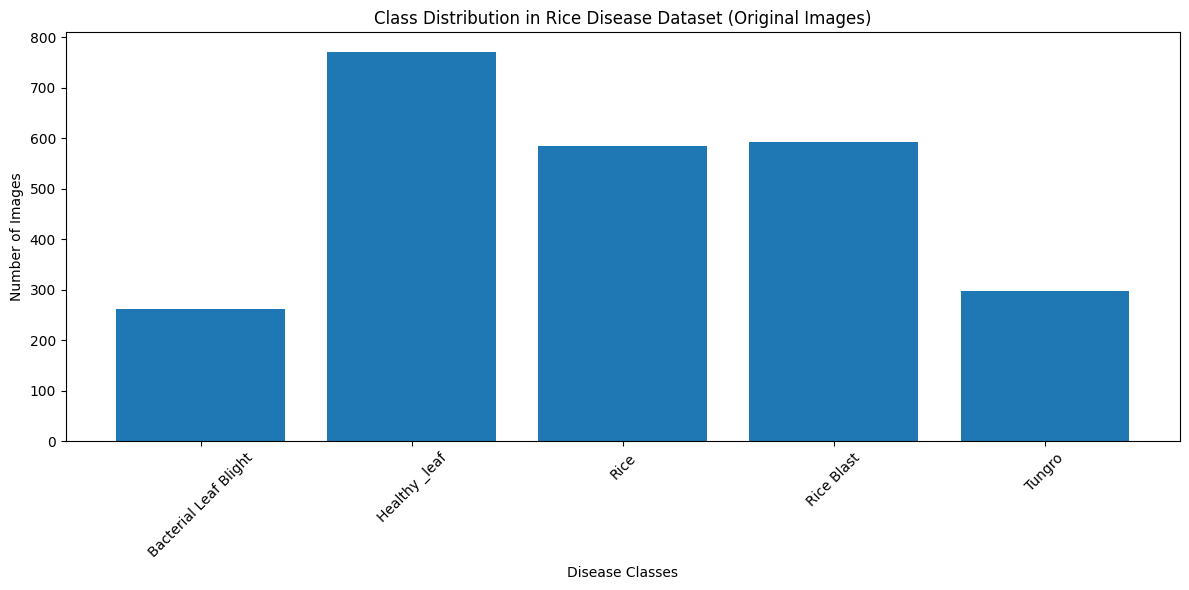

In [3]:
# Load and explore the dataset
class_counts = detector.load_and_explore_dataset()

## Step 3: Prepare Data Generators

In [4]:
# Prepare data generators with augmentation
train_gen, val_gen, test_gen = detector.prepare_data_generators(
    validation_split=0.2, 
    test_split=0.1
)

print("Data generators created successfully!")

=== Data Preparation ===
Creating temporary dataset structure at: C:\Users\fahim\AppData\Local\Temp\tmpjij6mv6m
Copied 262 images for Bacterial Leaf Blight
Copied 771 images for Healthy _leaf
Copied 585 images for Rice
Copied 592 images for Rice Blast
Copied 298 images for Tungro
Found 1758 images belonging to 5 classes.
Found 1673 images belonging to 5 classes.
Found 835 images belonging to 5 classes.
Training samples: 1758
Validation samples: 1673
Test samples: 835
Classes: {'Bacterial Leaf Blight': 0, 'Healthy _leaf': 1, 'Rice': 2, 'Rice Blast': 3, 'Tungro': 4}
Data generators created successfully!


## Step 4: Visualize Sample Images

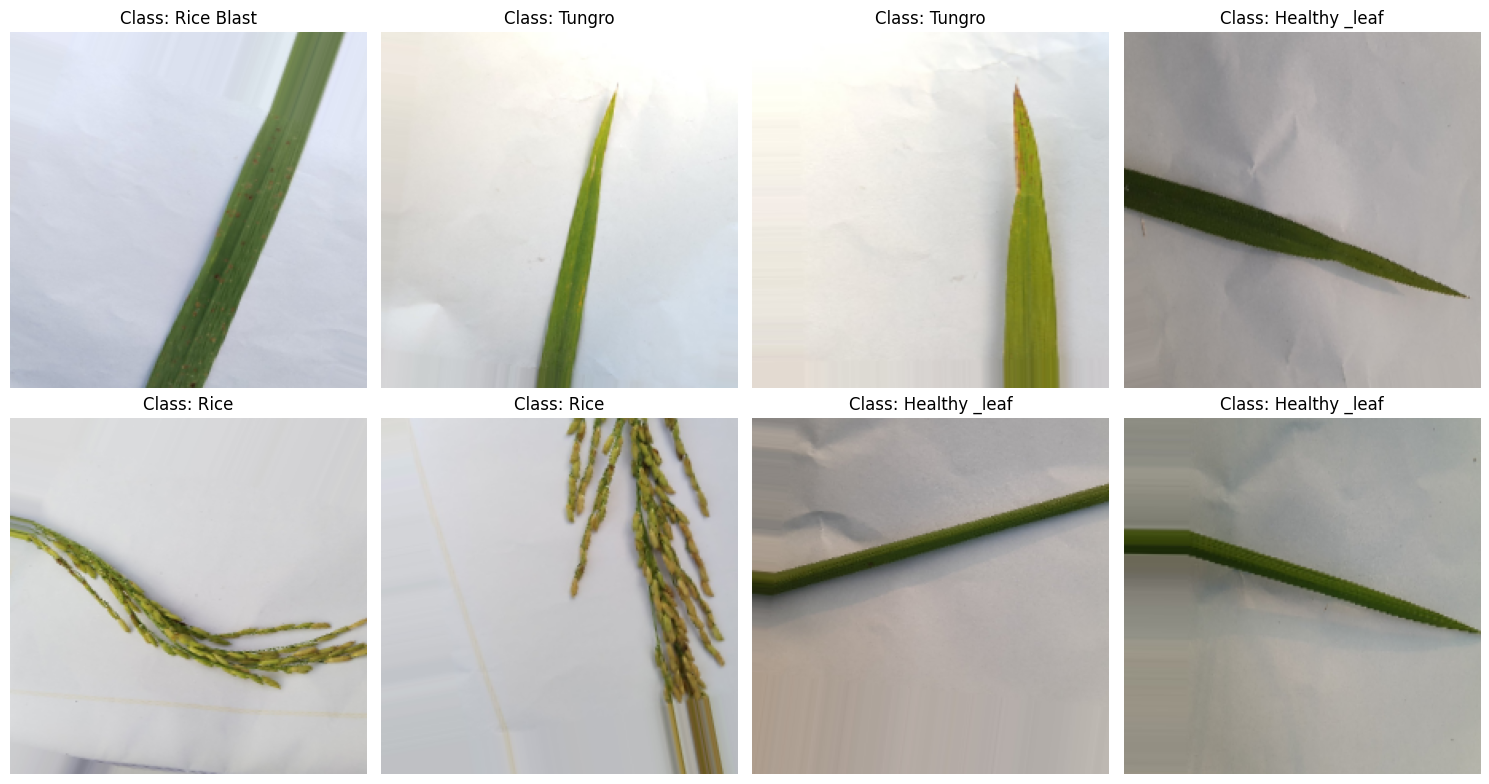

In [5]:
# Visualize some sample images from training set
def show_sample_images(generator, num_images=8):
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())
    
    plt.figure(figsize=(15, 8))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        class_idx = np.argmax(labels[i])
        plt.title(f'Class: {class_names[class_idx]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(train_gen)

## Step 5: Build the CNN Model

In [6]:
# Build CNN model (choose between custom CNN or transfer learning)
use_transfer_learning = True  # Set to False for custom CNN

model = detector.build_cnn_model(use_transfer_learning=use_transfer_learning)
print(f"Model built with transfer learning: {use_transfer_learning}")

=== Building CNN Model ===


9406464/9406464 [==============================] - 1s 0us/step

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                             

## Step 6: Train the Model

In [7]:
# Train the model
epochs = 30  # Adjust based on your needs
patience = 10

print(f"Starting training for {epochs} epochs...")
history = detector.train_model(train_gen, val_gen, epochs=epochs, patience=patience)
print("Training completed!")

Starting training for 30 epochs...
=== Training Model ===
Epoch 1/30


55/55 [==============================] - ETA: 0s - loss: 0.7470 - accuracy: 0.7139

C:\Users\fahim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/55 [==============================] - 101s 2s/step - loss: 0.7470 - accuracy: 0.7139 - val_loss: 0.5049 - val_accuracy: 0.8045 - lr: 0.0010
Epoch 2/30
55/55 [==============================] - 76s 1s/step - loss: 0.5461 - accuracy: 0.7878 - val_loss: 0.4224 - val_accuracy: 0.8320 - lr: 0.0010
Epoch 3/30
55/55 [==============================] - 74s 1s/step - loss: 0.4764 - accuracy: 0.8134 - val_loss: 0.3845 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 4/30
55/55 [==============================] - 74s 1s/step - loss: 0.4422 - accuracy: 0.8248 - val_loss: 0.4010 - val_accuracy: 0.8392 - lr: 0.0010
Epoch 5/30
55/55 [==============================] - 48s 872ms/step - loss: 0.4192 - accuracy: 0.8288 - val_loss: 0.4122 - val_accuracy: 0.8219 - lr: 0.0010
Epoch 6/30
55/55 [==============================] - 71s 1s/step - loss: 0.3948 - accuracy: 0.8373 - val_loss: 0.3652 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 7/30
55/55 [==============================] - 52s 951ms/step - loss: 0.3890 - accur

## Step 7: Visualize Training History

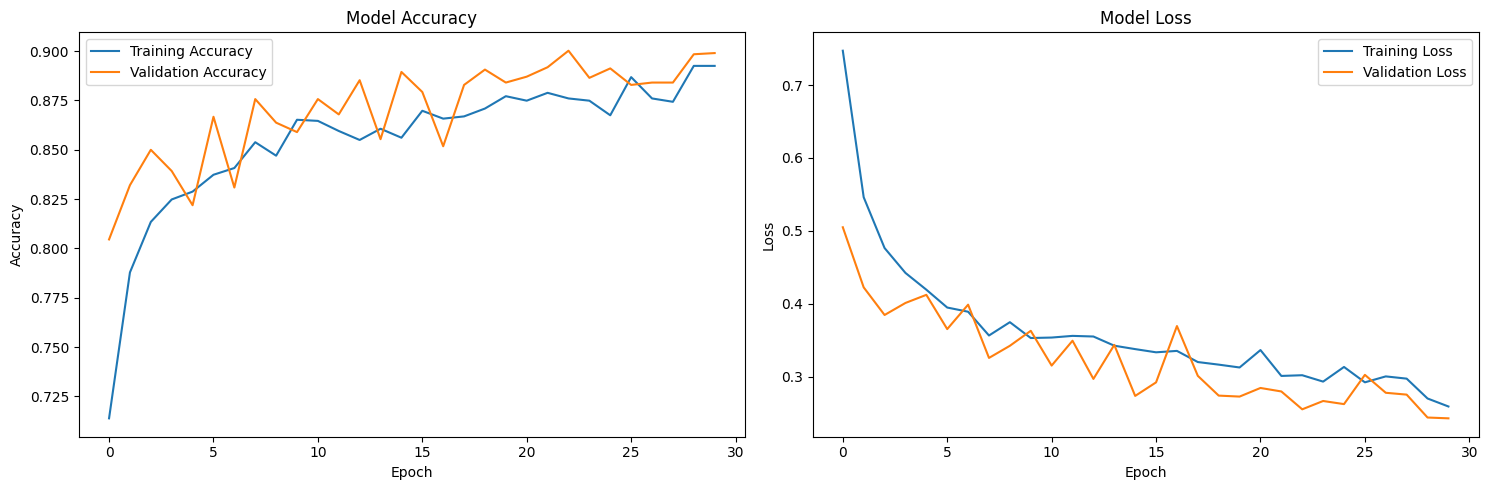

In [8]:
# Plot training history
detector.plot_training_history()

## Step 8: Evaluate the Model

=== Model Evaluation ===
Test Accuracy: 0.8299
Test Loss: 1.4226
27/27 [==============================] - 14s 399ms/step

Classification Report:
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.85      0.92      0.88        87
        Healthy _leaf       0.73      0.96      0.83       257
                 Rice       0.99      0.99      0.99       195
           Rice Blast       0.93      0.83      0.88       197
               Tungro       0.29      0.08      0.13        99

             accuracy                           0.83       835
            macro avg       0.76      0.76      0.74       835
         weighted avg       0.80      0.83      0.80       835



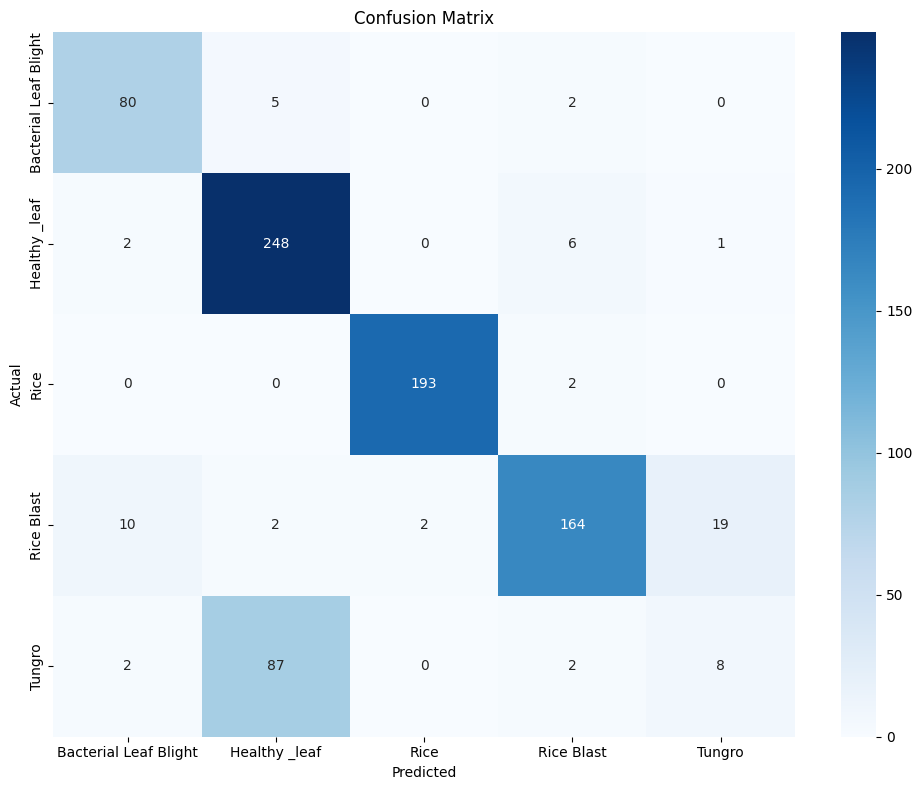

Final test accuracy: 0.8299


In [9]:
# Evaluate model on test set
eval_results = detector.evaluate_model(test_gen)
print(f"Final test accuracy: {eval_results['test_accuracy']:.4f}")

## Step 9: Save the Model

In [10]:
# Save the trained model
detector.save_model("rice_disease_cnn_model")
print("Model saved successfully!")

C:\Users\fahim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to f:\Personal\PrecisionAgriculture\mcp\rice-disease-detection\models\rice_disease_cnn_model.h5
Model saved successfully!


## Step 10: Test Single Image Prediction

In [12]:

test_image_path = "path/to/your/test/image.jpg"

# Uncomment and modify the path below to test
result = detector.predict_disease(test_image_path, return_probabilities=True)
if result:
    print(f"Predicted class: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("All probabilities:")
    for class_name, prob in result['all_probabilities'].items():
        print(f"  {class_name}: {prob:.4f}")

print("To test prediction, uncomment the code above and provide a test image path")

Error preprocessing image: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

To test prediction, uncomment the code above and provide a test image path


## Quick Prediction Function

In [13]:
# Quick prediction using saved model
# This function can be used independently after training

def test_quick_prediction(image_path):
    """Test the quick prediction function"""
    result = quick_prediction(image_path)
    if result:
        print(f"Quick prediction result:")
        print(f"Predicted class: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.4f}")
        return result
    else:
        print("Prediction failed")
        return None

# Example usage (uncomment and provide image path):
# test_quick_prediction("path/to/test/image.jpg")

print("Quick prediction function ready!")

Quick prediction function ready!
